# Imports

In [15]:
import os
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json
import yfinance as yf
from torch import sigmoid
#from pandas_datareader import data

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data

In [31]:
# retrieve historical data for specific company
# VSCO = Victoria Secret
ticker = 'VSCO'
start = '2015-03-25'
end = '2025-04-05'
stock_data = yf.download(ticker, start, end)

stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,VSCO,VSCO,VSCO,VSCO,VSCO
Date,,,,,
2021-07-21,42.500000,55.000000,39.994999,55.000000,96100
2021-07-22,40.900002,42.750000,39.790001,42.750000,401200
2021-07-23,42.139999,42.200001,40.990002,41.980000,114400
2021-07-26,41.200001,41.500000,40.060001,40.200001,22000
2021-07-27,41.435001,41.520000,41.099998,41.500000,83000


# Linear Regression Model

## Preprocess Data

In [39]:
# moving 10-day avg of closing prices
stock_data['MA_10'] = stock_data['Close'].rolling(window=10).mean()

# moving 15-day avg of closing prices
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()

In [40]:
# drop null values
stock_data = stock_data.dropna()

In [41]:
# define feature (x) and target (y)
X = stock_data[['Close', 'MA_10', 'MA_50']]
y = stock_data['Close'].shift(-1).dropna()
X = X[:-1]

In [42]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Model

In [43]:
# initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
# make predictions
predictions = model.predict(X_test)

In [45]:
# evaluate the model
mse_lin = mean_squared_error(y_test, predictions)
r2_lin = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse_lin}')
print(f'R² Score: {r2_lin}')

Mean Squared Error: 1.6945637353988763
R² Score: 0.9894312201616058


## Visualization

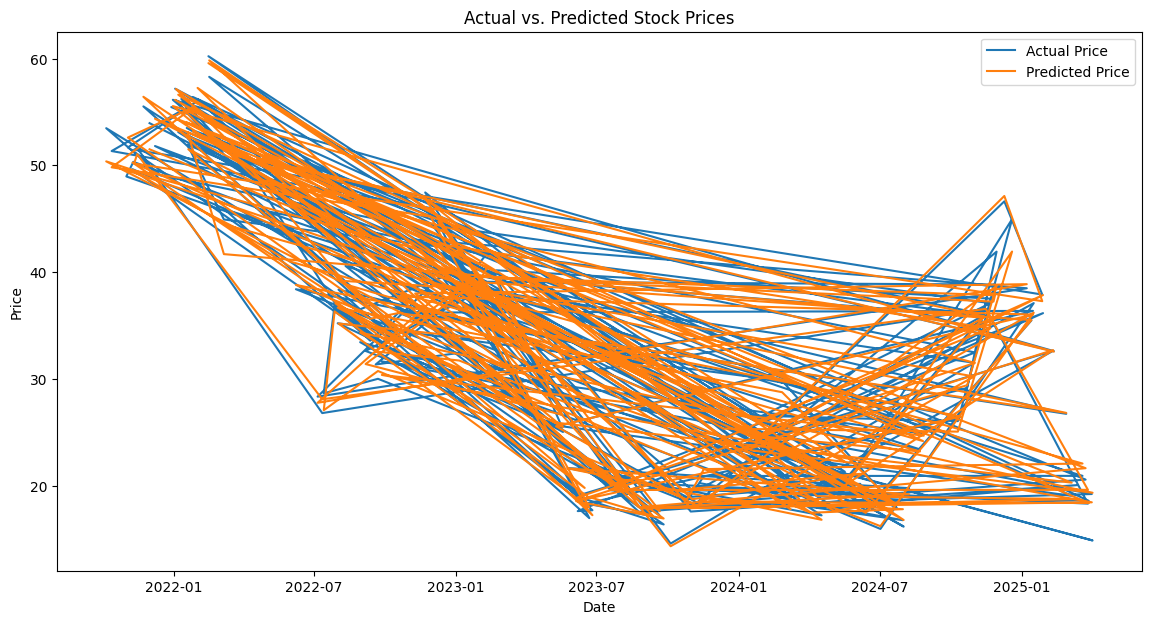

In [46]:
# define plot
plt.figure(figsize=(14, 7))

# data
plt.plot(y_test.index, y_test.values, label='Actual Price')
plt.plot(y_test.index, predictions, label='Predicted Price')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()

plt.show()

## Implementation

Implement a basic trading strategy based on the predictions that will buy when the predicted price is higher than the current price and sell when lower.

In [47]:
""" initial_balance = 10000  # starting balance (USD)
balance = initial_balance
position = 0  # no. of shares

for i in range(len(X_test)):
    current_price = X_test.iloc[i]['Close']
    predicted_price = predictions[i]

    if predicted_price > current_price and balance >= current_price:
        # buy stock
        shares_to_buy = int(balance // current_price)  # buy whole shares only
        if shares_to_buy > 0:
            # buy at least one share
            position += shares_to_buy
            balance -= shares_to_buy * current_price
            print('Buying {shares_to_buy} shares at {current_price}')

    elif predicted_price < current_price and position > 0:
        # sell stock
        balance += position * current_price
        print('Selling {position} shares at {current_price}')
        position = 0

# calculate final balance including the value of the remaining shares
final_balance = balance + (position * X_test.iloc[-1]['Close'])
profit = final_balance - initial_balance

print(f"Final balance: ${final_balance:.2f}")
print(f"Profit: ${profit:.2f}") """

' initial_balance = 10000  # starting balance (USD)\nbalance = initial_balance\nposition = 0  # no. of shares\n\nfor i in range(len(X_test)):\n    current_price = X_test.iloc[i][\'Close\']\n    predicted_price = predictions[i]\n\n    if predicted_price > current_price and balance >= current_price:\n        # buy stock\n        shares_to_buy = int(balance // current_price)  # buy whole shares only\n        if shares_to_buy > 0:\n            # buy at least one share\n            position += shares_to_buy\n            balance -= shares_to_buy * current_price\n            print(\'Buying {shares_to_buy} shares at {current_price}\')\n\n    elif predicted_price < current_price and position > 0:\n        # sell stock\n        balance += position * current_price\n        print(\'Selling {position} shares at {current_price}\')\n        position = 0\n\n# calculate final balance including the value of the remaining shares\nfinal_balance = balance + (position * X_test.iloc[-1][\'Close\'])\nprofit =

# LSTM Model

## Preprocess Data

In [32]:
# use closing prices for prediction
close = stock_data['Close'].values

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(close.reshape(-1, 1))

# split into training and test data
train_size = int(len(close_scaled) * 0.8)
train_data, test_data = close_scaled[:train_size], close_scaled[train_size:]

In [ ]:
# create sequences of past stock prices (features, x) and next stock price (target, y)
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

""" def create_sequences(data, seq_len, forecast_len):
    x, y = [], []
    for i in range(seq_len, len(data)-forecast_len+1):
        x.append(data[i-seq_len:i, 0])
        y.append(data[i: i+forecast_len])
    return np.array(x), np.array(y) """

seq_len = 60            # use previous 60 days to predict next day's price
forecast_len = 30       # predict 30 days out

# create sequences from training and test data
x_train, y_train = create_sequences(train_data, seq_len)
x_test, y_test = create_sequences(test_data, seq_len)

# reshape the input data to be compatible with LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [64]:
last_seq = x_test[-1]  # shape: (timesteps, 1)
predictions = []

""" for i in range(forecast_len):
    # add batch dimension: shape (1, timesteps, 1)
    input_seq = np.expand_dims(last_seq, axis=0)
    
    # predict next value
    pred = model.predict(input_seq, verbose=0)[0][0]
    predictions.append(pred)
    
    # ipdate last_seq by appending the prediction and removing the first time step
    last_seq = np.append(last_seq[1:], [[pred]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) """


def forecast_future(model, last_seq, steps, scaler=None):
    predictions = []
    current_seq = last_seq.copy()
    
    for i in range(steps):
        input_seq = np.expand_dims(current_seq, axis=0)
        pred = model.predict(input_seq, verbose=0)[0][0]
        predictions.append(pred)
        current_seq = np.append(current_seq[1:], [[pred]], axis=0)

    predictions = np.array(predictions).reshape(-1, 1)
    if scaler:
        predictions = scaler.inverse_transform(predictions)
    return predictions


## Build LSTM Model

In [54]:
# build model
model = Sequential([
    LSTM(units=50, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dense(units=1   #, activation='relu'
          ),
    Dense(units=1   #, activation='sigmoid'
          )
])

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# train model
model.fit(x_train, y_train, epochs=100, batch_size=32)

# evaluate model
train_loss = model.evaluate(x_train, y_train, verbose=0)
test_loss = model.evaluate(x_test, y_test, verbose=0)

print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')


Epoch 1/100


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2014
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0197
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0115
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0083
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0080
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0082
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0078
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0075
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0078
E

## Predictions

In [56]:
# predict stock prices on test data
predictions = model.predict(x_test).reshape(-1, 1)

# inverse transform predictions back to original price scale
predictions = scaler.inverse_transform(predictions)

# inverse transform actual test data
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

print(predictions)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f163c477f60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[23.86968 ]
 [23.601103]
 [23.046352]
 [22.625051]
 [22.299171]
 [22.184278]
 [22.19141 ]
 [22.396412]
 [22.884592]
 [23.453894]
 [23.931469]
 [24.75944 ]
 [25.297749]
 [25.603489]
 [26.040436]
 [26.5

## Evaluation

In [57]:
# calculate MSE, RMSE, R^2
mse_lstm = mean_squared_error(y_test_scaled, predictions)
rmse_lstm = np.sqrt(mse_lstm)
#r2_lstm = r2_score(y_test_scaled, predictions)

#print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse_lstm}')
#print(f'R² Score: {r2_lstm}')

ValueError: Found input variables with inconsistent numbers of samples: [2940, 98]

## Visualizations

### Plot

In [58]:
fig = go.Figure()

# actual prices
fig.add_trace(go.Scatter(x=stock_data.index[-(seq_len+forecast_len):],
                         y=y_test_scaled.flatten(),
                         mode='lines',
                         name='Actual Price'))

# predicted prices
fig.add_trace(go.Scatter(x=stock_data.index[-(seq_len+forecast_len):],
                         y=predictions.flatten(),
                         mode='lines',
                         name='Predicted Price'))

# labels
fig.update_layout(title='VS Stock Prediction',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (USD)')

fig.show()

### Predictions with Matplotlib

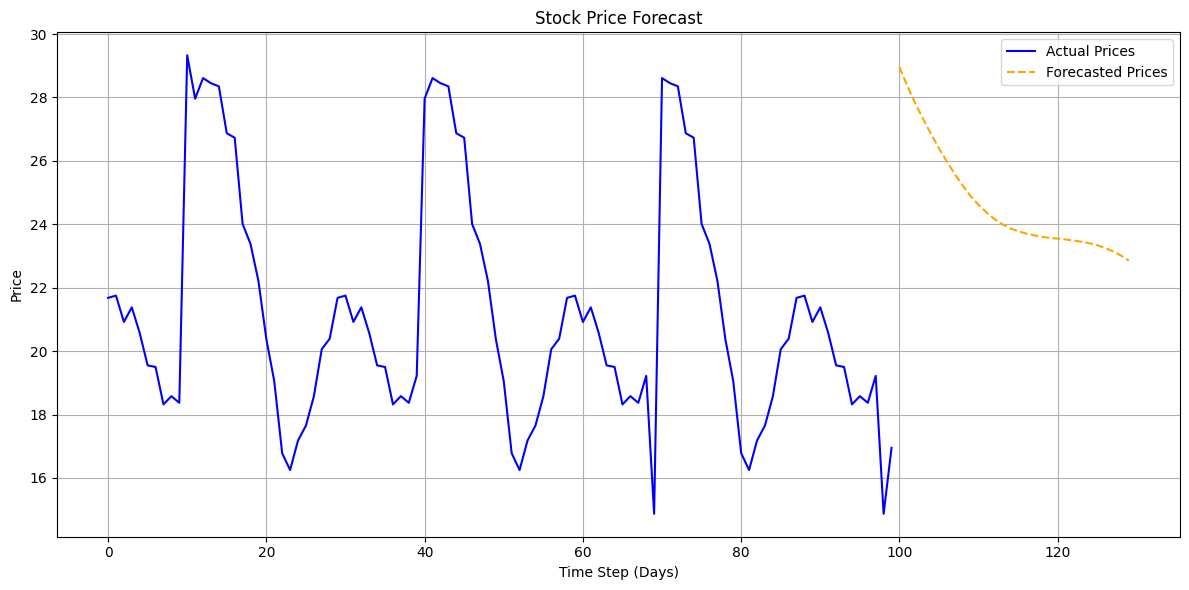

In [61]:
# Assume y_test was scaled and you want to see the last known 50 values
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

look_back = 100  # how much of the past to show
context_prices = actual_prices[-look_back:]

# Build x-axis range
x_context = list(range(look_back))
x_future = list(range(look_back, look_back + forecast_len))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x_context, context_prices, label="Actual Prices", color='blue')
plt.plot(x_future, predictions, label="Forecasted Prices", color='orange', linestyle='--')
plt.xlabel("Time Step (Days)")
plt.ylabel("Price")
plt.title("Stock Price Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Predictions with Plotly

In [65]:
look_back = 100
forecast_len = 90

# generate forecast
predictions = forecast_future(model, x_test[-1], steps=forecast_len, scaler=scaler)

# recover actual values (inverse scaled)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
context_prices = actual_prices[-look_back:].flatten()

# Combine for full plot
x_actual = list(range(look_back))
x_forecast = list(range(look_back, look_back + forecast_len))

In [67]:
# add actual price trace
fig.add_trace(go.Scatter(
    x=x_actual,
    y=context_prices,
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))

# add forecast trace
fig.add_trace(go.Scatter(
    x=x_forecast,
    y=predictions.flatten(),
    mode='lines+markers',
    name='Forecasted Prices',
    line=dict(color='orange', dash='dash')
))

# layout
fig.update_layout(
    title='📈 Stock Price Forecast with LSTM',
    xaxis_title='Time Step (Days)',
    yaxis_title='Price',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99),
    margin=dict(t=50, b=40, l=50, r=40)
)

fig.show()